# Forecasting Mechanisms: Multi-step Ahead and Probabilistic Forecasting

In this lab, you will explore different strategies for multi-step ahead forecasting
and implement probabilistic forecasting models. You will learn about:
- Direct vs. autoregressive forecasting approaches
- Curriculum learning and scheduled sampling for autoregressive models
- Probabilistic losses (Gaussian NLL, quantile loss)
- Uncertainty visualization

In [1]:
import math
import numpy
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

## Part 1: Direct vs. Autoregressive Forecasting

In this section, you will compare two approaches to multi-step ahead forecasting:
1. **Direct forecasting**: Predict all future steps in one forward pass
2. **Autoregressive forecasting**: Iteratively predict one step at a time

Below is a dataloader for the univariate ETTh1 dataset from previous labs, code for a direct
forecasting model as well as a training loop.

In [2]:
class ForecastingDataset(torch.utils.data.Dataset):
    """Windowed univariate forecasting dataset."""

    def __init__(self, 
                 csv_path: str, 
                 window: int, 
                 horizon: int, 
                 target_col: int = -1,
                 start: int = 0,
                 end: int = None):
        super().__init__()
        raw = numpy.loadtxt(csv_path, delimiter=",", skiprows=1, usecols=target_col)
        series = raw.astype(numpy.float32)
        if end is None:
            series = series[start:]
        else:
            series = series[start:end]
        self.window = window
        self.horizon = horizon
        self.series = series
        self.max_start = len(series) - window - horizon + 1
        if self.max_start < 1:
            raise ValueError("Window + horizon larger than available series length")

    def __len__(self):
        return self.max_start

    def __getitem__(self, idx: int):
        start = idx
        past = self.series[start : start + self.window]
        future = self.series[start + self.window : start + self.window + self.horizon]
        past = torch.from_numpy(past)  # shape: (window,)
        future = torch.from_numpy(future)  # shape: (horizon,)
        return past, future


def build_dataloader(csv_path: str, 
                     window: int, 
                     horizon: int, 
                     batch_size: int = 32, 
                     shuffle: bool = True):
    """Create a DataLoader emitting `(past, horizon)` batches."""
    dataset = ForecastingDataset(csv_path=csv_path, 
                                 window=window, 
                                 horizon=horizon)
    n = len(dataset)
    n_train = int(0.8 * n)
    train_dataset = ForecastingDataset(csv_path=csv_path, 
                                      window=window, 
                                      horizon=horizon,
                                      end=n_train)
    valid_dataset = ForecastingDataset(csv_path=csv_path, 
                                       window=window, 
                                       horizon=horizon,
                                       start=n_train)
    train_dl = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=shuffle, 
                                           drop_last=False)
    valid_dl = torch.utils.data.DataLoader(valid_dataset,
                                           batch_size=batch_size, 
                                           shuffle=False, 
                                           drop_last=False)
    return train_dl, valid_dl


# Direct forecasting model: predicts all steps at once
class DirectForecaster(nn.Module):
    """Direct forecasting: predict all horizon steps in one forward pass."""
    
    def __init__(self, window: int, horizon: int, hidden_dim: int = 64):
        super().__init__()
        self.window = window
        self.horizon = horizon
        self.net = nn.Sequential(
            nn.Linear(window, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, horizon)
        )
    
    def forward(self, past):
        # past: (batch, window)
        # output: (batch, horizon)
        return self.net(past)


# Training and evaluation functions
def train_epoch(model, dataloader, optimizer, criterion, use_teacher_forcing=False):
    model.train()
    total_loss = 0.0
    for past, future in dataloader:
        optimizer.zero_grad()
        if isinstance(model, AutoregressiveForecaster):
            pred = model(past, use_ground_truth=use_teacher_forcing, ground_truth=future)
        else:
            pred = model(past)
        loss = criterion(pred, future)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * past.size(0)
    return total_loss / len(dataloader.dataset)


@torch.no_grad()
def eval_epoch(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    for past, future in dataloader:
        if isinstance(model, AutoregressiveForecaster):
            pred = model(past, use_ground_truth=False)
        else:
            pred = model(past)
        loss = criterion(pred, future)
        total_loss += loss.item() * past.size(0)
    return total_loss / len(dataloader.dataset)


def train_and_valid_loop(model, train_dl, valid_dl, optimizer, criterion, n_epochs, 
                         use_teacher_forcing=False):
    logs = {"train_loss": [], "valid_loss": []}
    print(model.__class__.__name__)
    for epoch in range(n_epochs):
        train_loss = train_epoch(model, train_dl, optimizer, criterion, use_teacher_forcing)
        logs["train_loss"].append(train_loss)
        valid_loss = eval_epoch(model, valid_dl, criterion)
        logs["valid_loss"].append(valid_loss)
        print(f"Epoch {epoch:02d} | train={train_loss:.4f} | valid={valid_loss:.4f}")
    return logs



**Question 1.** Implement an autoregressive forecasting model using the code template below.
The model should allow:
- teacher forcing
- injection of ground truth in the sliding window fed as input of the model
- curriculum learning (which could be implemented by providing only the first 
  few future steps in the `ground_truth` tensor)
- scheduled sampling through the specification of a probability `p`

In [3]:
# Autoregressive forecasting model: predicts one step at a time
class AutoregressiveForecaster(nn.Module):
    """Autoregressive forecasting: iteratively predict one step at a time."""
    
    def __init__(self, window: int, horizon: int, hidden_dim: int = 64):
        super().__init__()
        self.window = window
        self.horizon = horizon
        # Model that predicts one step ahead
        self.step_model = nn.Sequential(
            nn.Linear(window, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, past, use_ground_truth=False, ground_truth=None, p=None):
        predictions = []
        current_window = past.clone()  # (batch, window)
        
        for h in range(self.horizon):
            # TODO: your code goes here
            pass
            
            # Shift window: remove first element, add prediction
            # current_window = torch.cat([current_window[:, 1:], next_value], dim=1)
        
        return torch.stack(predictions, dim=1)  # (batch, horizon)

In [4]:
# Autoregressive forecasting model: predicts one step at a time
class AutoregressiveForecaster(nn.Module):
    """Autoregressive forecasting: iteratively predict one step at a time."""
    
    def __init__(self, window: int, horizon: int, hidden_dim: int = 64):
        super().__init__()
        self.window = window
        self.horizon = horizon
        # Model that predicts one step ahead
        self.step_model = nn.Sequential(
            nn.Linear(window, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, past, use_ground_truth=False, ground_truth=None, p=None):
        predictions = []
        current_window = past.clone()  # (batch, window)
        
        for h in range(self.horizon):
            # Predict one step ahead
            next_step = self.step_model(current_window)  # (batch, 1)
            predictions.append(next_step.squeeze(-1))  # (batch,)
            
            # Update window: shift and add prediction
            if use_ground_truth and (ground_truth is not None) and p is not None:
                # Probabilistic teacher forcing:
                # with probability p use ground truth, otherwise use model prediction
                mask = (torch.rand_like(next_step) < p).float()  # (batch, 1)
                next_value = mask * ground_truth[:, h:h+1] + (1 - mask) * next_step
            elif use_ground_truth and (ground_truth is not None):
                # Deterministic teacher forcing: always use ground truth
                next_value = ground_truth[:, h:h+1]  # (batch, 1)
            else:
                # Use own prediction
                next_value = next_step
            
            # Shift window: remove first element, add prediction
            current_window = torch.cat([current_window[:, 1:], next_value], dim=1)
        
        return torch.stack(predictions, dim=1)  # (batch, horizon)

# Train both models
window = 96
horizon = 24
train_dl, valid_dl = build_dataloader("data/ETTh1.csv", window=window, horizon=horizon, batch_size=64)

# Direct forecaster
direct_model = DirectForecaster(window, horizon)
optimizer_direct = torch.optim.Adam(direct_model.parameters(), lr=1e-4)
criterion = nn.MSELoss()
logs_direct = train_and_valid_loop(direct_model, train_dl, valid_dl, optimizer_direct, 
                                    criterion, n_epochs=20)

# Autoregressive forecaster (with teacher forcing during training)
ar_model = AutoregressiveForecaster(window, horizon)
optimizer_ar = torch.optim.Adam(ar_model.parameters(), lr=1e-4)
logs_ar = train_and_valid_loop(ar_model, train_dl, valid_dl, optimizer_ar, 
                                criterion, n_epochs=20, use_teacher_forcing=True)

DirectForecaster
Epoch 00 | train=129.6136 | valid=7.0661
Epoch 01 | train=10.2692 | valid=5.6067
Epoch 02 | train=8.4895 | valid=4.4186
Epoch 03 | train=7.5754 | valid=4.0096
Epoch 04 | train=7.1612 | valid=3.7722
Epoch 05 | train=6.9083 | valid=3.6856
Epoch 06 | train=6.7085 | valid=3.6061
Epoch 07 | train=6.5795 | valid=3.5355
Epoch 08 | train=6.4801 | valid=3.5238
Epoch 09 | train=6.3783 | valid=3.4768
Epoch 10 | train=6.3352 | valid=3.4499
Epoch 11 | train=6.2492 | valid=3.5008
Epoch 12 | train=6.1417 | valid=3.4552
Epoch 13 | train=6.1048 | valid=3.4504
Epoch 14 | train=6.0434 | valid=3.3580
Epoch 15 | train=5.9939 | valid=3.3750
Epoch 16 | train=5.9527 | valid=3.3421
Epoch 17 | train=5.9058 | valid=3.3145
Epoch 18 | train=5.8334 | valid=3.3267
Epoch 19 | train=5.7910 | valid=3.2878
AutoregressiveForecaster
Epoch 00 | train=73.3545 | valid=5.3319
Epoch 01 | train=4.6910 | valid=3.9372
Epoch 02 | train=2.7664 | valid=3.6992
Epoch 03 | train=2.1388 | valid=3.5918
Epoch 04 | train=1

## Part 2: Curriculum Learning for Autoregressive Models

Curriculum learning gradually increases the prediction horizon during training,
helping the model learn to handle its own predictions progressively.

**Question 2.** Implement a curriculum learning training loop for the autoregressive model:
- Start by training to predict 1 step ahead
- Gradually increase to 2, 4, 8, ... steps ahead
- Finally train on the full horizon
- Compare with the baseline autoregressive model

AutoregressiveForecaster with Curriculum Learning

Stage 1/5: Predicting 1 steps ahead
Epoch 00 | train=60.9258 | valid=5.3074
Epoch 01 | train=4.8302 | valid=3.7141
Epoch 02 | train=3.0529 | valid=3.4882
Epoch 03 | train=2.3528 | valid=3.3882
Epoch 04 | train=1.9966 | valid=3.3935

Stage 2/5: Predicting 2 steps ahead
Epoch 00 | train=1.8226 | valid=3.3136
Epoch 01 | train=1.6675 | valid=3.5594
Epoch 02 | train=1.5585 | valid=3.4112
Epoch 03 | train=1.4550 | valid=3.5574
Epoch 04 | train=1.4019 | valid=3.5722

Stage 3/5: Predicting 4 steps ahead
Epoch 00 | train=1.3480 | valid=3.3613
Epoch 01 | train=1.2898 | valid=3.3826
Epoch 02 | train=1.2455 | valid=3.4289
Epoch 03 | train=1.1992 | valid=3.2634
Epoch 04 | train=1.1675 | valid=3.3080

Stage 4/5: Predicting 8 steps ahead
Epoch 00 | train=1.1327 | valid=3.4617
Epoch 01 | train=1.1131 | valid=3.2261
Epoch 02 | train=1.0850 | valid=3.2775
Epoch 03 | train=1.0636 | valid=3.3512
Epoch 04 | train=1.0389 | valid=3.5733

Stage 5/5: Predictin

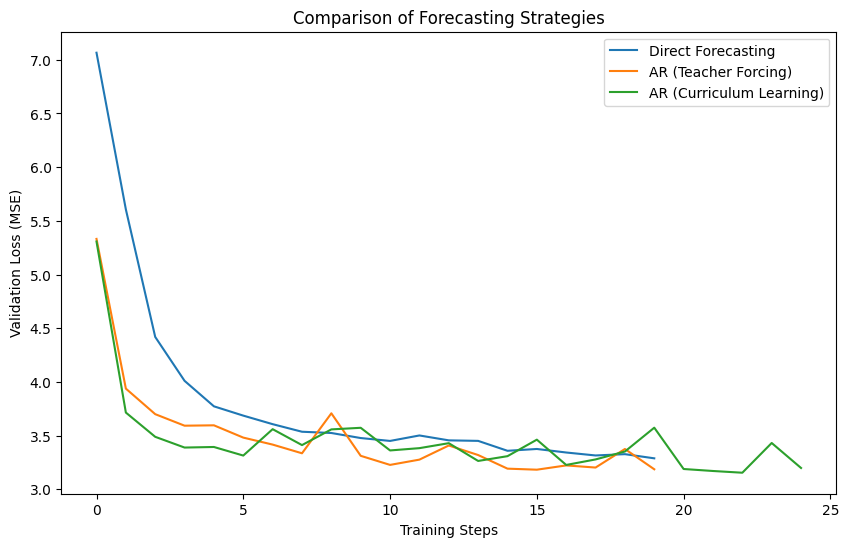

In [5]:
def train_epoch_curriculum(model, dataloader, optimizer, criterion, target_horizon):
    model.train()
    total_loss = 0.0
    for past, future in dataloader:
        optimizer.zero_grad()
        if isinstance(model, AutoregressiveForecaster):
            pred = model(past, use_ground_truth=True, ground_truth=future)
        else:
            pred = model(past)
        loss = criterion(pred[:, :target_horizon], future[:, :target_horizon])
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * past.size(0)
    return total_loss / len(dataloader.dataset)


def train_curriculum(model, train_dl, valid_dl, optimizer, criterion, n_epochs_per_stage=5):
    """Train with curriculum learning: gradually increase prediction horizon."""
    logs = {"train_loss": [], "valid_loss": []}
    print(f"{model.__class__.__name__} with Curriculum Learning")
    
    # Curriculum stages: gradually increase horizon
    max_horizon = train_dl.dataset.horizon
    curriculum_stages = [1, 2, 4, 8, max_horizon]
    curriculum_stages = [h for h in curriculum_stages if h <= max_horizon]
    
    for stage, target_horizon in enumerate(curriculum_stages):
        print(f"\nStage {stage+1}/{len(curriculum_stages)}: Predicting {target_horizon} steps ahead")
        for epoch in range(n_epochs_per_stage):
            train_loss = train_epoch_curriculum(model, train_dl, optimizer, criterion, target_horizon)
            logs["train_loss"].append(train_loss)
            valid_loss = eval_epoch(model, valid_dl, criterion)
            logs["valid_loss"].append(valid_loss)
            print(f"Epoch {epoch:02d} | train={train_loss:.4f} | valid={valid_loss:.4f}")
    return logs

# Train with curriculum learning
ar_model_curriculum = AutoregressiveForecaster(window, horizon)
optimizer_curriculum = torch.optim.Adam(ar_model_curriculum.parameters(), lr=1e-4)
logs_ar_curriculum = train_curriculum(ar_model_curriculum, train_dl, valid_dl, 
                                       optimizer_curriculum, criterion, n_epochs_per_stage=5)

# Compare results
plt.figure(figsize=(10, 6))
plt.plot(logs_direct["valid_loss"], label="Direct Forecasting")
plt.plot(logs_ar["valid_loss"], label="AR (Teacher Forcing)")
plt.plot(logs_ar_curriculum["valid_loss"], label="AR (Curriculum Learning)")
plt.xlabel("Training Steps")
plt.ylabel("Validation Loss (MSE)")
plt.legend()
plt.title("Comparison of Forecasting Strategies")
plt.show()

## Part 3: Scheduled Sampling

Scheduled sampling randomly replaces ground truth with model predictions during
training, with the probability of using predictions increasing over time.

**Question 3.** Implement scheduled sampling for the autoregressive model:
- Start with probability p=1.0 (always use ground truth)
- Gradually decrease p to 0.0 (always use predictions)
- Compare with baseline autoregressive model

AutoregressiveForecaster with Scheduled Sampling
Epoch 00 | train=42.0812 | valid=4.4946
Epoch 01 | train=3.3690 | valid=3.4484
Epoch 02 | train=2.3740 | valid=3.5050
Epoch 03 | train=2.1307 | valid=3.6952
Epoch 04 | train=1.9874 | valid=3.3770
Epoch 05 | train=1.9378 | valid=3.3693
Epoch 06 | train=1.8959 | valid=3.3077
Epoch 07 | train=1.9073 | valid=3.5910
Epoch 08 | train=1.9712 | valid=3.2915
Epoch 09 | train=1.9709 | valid=3.4292
Epoch 10 | train=2.0470 | valid=3.3080
Epoch 11 | train=2.1844 | valid=4.3685
Epoch 12 | train=2.3201 | valid=3.4774
Epoch 13 | train=2.5234 | valid=3.9255
Epoch 14 | train=2.7060 | valid=3.4383
Epoch 15 | train=3.0855 | valid=3.5532
Epoch 16 | train=3.5973 | valid=3.3083
Epoch 17 | train=4.1513 | valid=3.4213
Epoch 18 | train=4.8428 | valid=3.2598
Epoch 19 | train=5.8671 | valid=3.2022


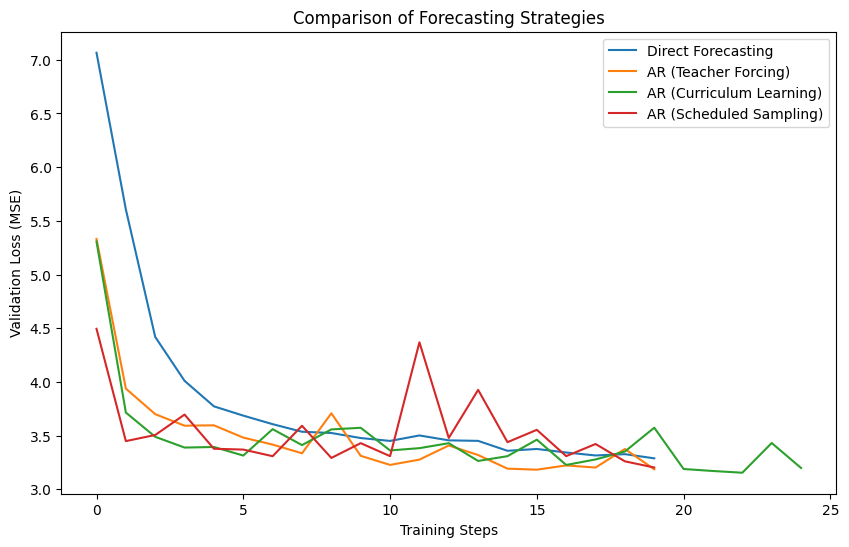

In [6]:
def train_epoch_scheduled_sampling(model, dataloader, optimizer, criterion, p):
    model.train()
    total_loss = 0.0
    for past, future in dataloader:
        optimizer.zero_grad()
        if isinstance(model, AutoregressiveForecaster):
            pred = model(past, use_ground_truth=True, ground_truth=future, p=p)
        else:
            pred = model(past)
        loss = criterion(pred, future)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * past.size(0)
    return total_loss / len(dataloader.dataset)

def train_scheduled_sampling(model, train_dl, valid_dl, optimizer, criterion, n_epochs=20):
    """Train with scheduled sampling: gradually increase use of own predictions."""
    logs = {"train_loss": [], "valid_loss": []}
    print(f"{model.__class__.__name__} with Scheduled Sampling")
    
    for epoch in range(n_epochs):
        p = float(n_epochs - 1 - epoch) / (n_epochs - 1)
        train_loss = train_epoch_scheduled_sampling(model, train_dl, optimizer, criterion, p)
        logs["train_loss"].append(train_loss)
        valid_loss = eval_epoch(model, valid_dl, criterion)
        logs["valid_loss"].append(valid_loss)
        print(f"Epoch {epoch:02d} | train={train_loss:.4f} | valid={valid_loss:.4f}")
    return logs

# Train with scheduled sampling
ar_model_scheduled = AutoregressiveForecaster(window, horizon)
optimizer_scheduled = torch.optim.Adam(ar_model_scheduled.parameters(), lr=1e-4)
logs_ar_scheduled = train_scheduled_sampling(ar_model_scheduled, train_dl, valid_dl, 
                                             optimizer_scheduled, criterion, n_epochs=20)

# Update comparison plot
plt.figure(figsize=(10, 6))
plt.plot(logs_direct["valid_loss"], label="Direct Forecasting")
plt.plot(logs_ar["valid_loss"], label="AR (Teacher Forcing)")
plt.plot(logs_ar_curriculum["valid_loss"], label="AR (Curriculum Learning)")
plt.plot(logs_ar_scheduled["valid_loss"], label="AR (Scheduled Sampling)")
plt.xlabel("Training Steps")
plt.ylabel("Validation Loss (MSE)")
plt.legend()
plt.title("Comparison of Forecasting Strategies")
plt.show()

## Part 4: Probabilistic Forecasting with Gaussian NLL

Instead of predicting point estimates, probabilistic models predict distributions.
We'll start with a Gaussian distribution parameterized by mean and variance.

**Question 4.** Implement a probabilistic forecasting model that outputs both mean
and (log-)variance, and train it using negative log-likelihood (NLL) loss.

In [7]:
class ProbabilisticForecaster(nn.Module):
    """Probabilistic forecaster: outputs mean and variance for Gaussian distribution."""
    
    def __init__(self, window: int, horizon: int, hidden_dim: int = 64):
        super().__init__()
        self.window = window
        self.horizon = horizon
        
        # Shared encoder
        self.encoder = nn.Sequential(
            nn.Linear(window, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        
        # Mean head
        self.mean_head = nn.Linear(hidden_dim, horizon)
        
        # Variance head (outputs log-variance for numerical stability)
        self.logvar_head = nn.Linear(hidden_dim, horizon)
    
    def forward(self, past):
        """
        Args:
            past: (batch, window)
        Returns:
            mean: (batch, horizon) - predicted mean
            logvar: (batch, horizon) - predicted log-variance
        """
        features = self.encoder(past)
        mean = self.mean_head(features)
        logvar = self.logvar_head(features)
        return mean, logvar


def gaussian_nll_loss(mean, logvar, target):
    """
    Negative log-likelihood for Gaussian distribution.
    
    Args:
        mean: (batch, horizon) - predicted mean
        logvar: (batch, horizon) - predicted log-variance
        target: (batch, horizon) - ground truth values
    Returns:
        loss: scalar
    """
    var = torch.exp(logvar)
    nll = 0.5 * (logvar + (target - mean) ** 2 / var + math.log(2 * math.pi))
    return nll.mean()


def train_probabilistic(model, dataloader, optimizer, n_epochs=20):
    """Train probabilistic model with NLL loss."""
    logs = {"train_loss": [], "valid_loss": []}
    print(model.__class__.__name__)
    
    for epoch in range(n_epochs):
        # Training
        model.train()
        total_loss = 0.0
        for past, future in dataloader:
            optimizer.zero_grad()
            mean, logvar = model(past)
            loss = gaussian_nll_loss(mean, logvar, future)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * past.size(0)
        train_loss = total_loss / len(dataloader.dataset)
        logs["train_loss"].append(train_loss)
        
        # Validation
        model.eval()
        total_loss = 0.0
        with torch.no_grad():
            for past, future in dataloader:
                mean, logvar = model(past)
                loss = gaussian_nll_loss(mean, logvar, future)
                total_loss += loss.item() * past.size(0)
        valid_loss = total_loss / len(dataloader.dataset)
        logs["valid_loss"].append(valid_loss)
        
        print(f"Epoch {epoch:02d} | train={train_loss:.4f} | valid={valid_loss:.4f}")
    
    return logs

# Train probabilistic model
prob_model = ProbabilisticForecaster(window, horizon)
optimizer_prob = torch.optim.Adam(prob_model.parameters(), lr=1e-4)
logs_prob = train_probabilistic(prob_model, train_dl, optimizer_prob, n_epochs=20)

ProbabilisticForecaster
Epoch 00 | train=55.1685 | valid=4.7363
Epoch 01 | train=4.1904 | valid=3.8424
Epoch 02 | train=3.4054 | valid=2.9223
Epoch 03 | train=2.7448 | valid=2.6472
Epoch 04 | train=2.5979 | valid=2.5491
Epoch 05 | train=2.5182 | valid=2.4924
Epoch 06 | train=2.4694 | valid=2.4471
Epoch 07 | train=2.4347 | valid=2.4192
Epoch 08 | train=2.4056 | valid=2.3912
Epoch 09 | train=2.3839 | valid=2.3739
Epoch 10 | train=2.3671 | valid=2.3623
Epoch 11 | train=2.3552 | valid=2.3539
Epoch 12 | train=2.3416 | valid=2.3350
Epoch 13 | train=2.3300 | valid=2.3228
Epoch 14 | train=2.3201 | valid=2.3160
Epoch 15 | train=2.3075 | valid=2.2993
Epoch 16 | train=2.2980 | valid=2.2896
Epoch 17 | train=2.2887 | valid=2.2945
Epoch 18 | train=2.2796 | valid=2.2732
Epoch 19 | train=2.2715 | valid=2.2634


**Question 5.** Visualize the probabilistic forecasts with uncertainty intervals.
Show the mean prediction along with confidence intervals (e.g., 50% and 90%).

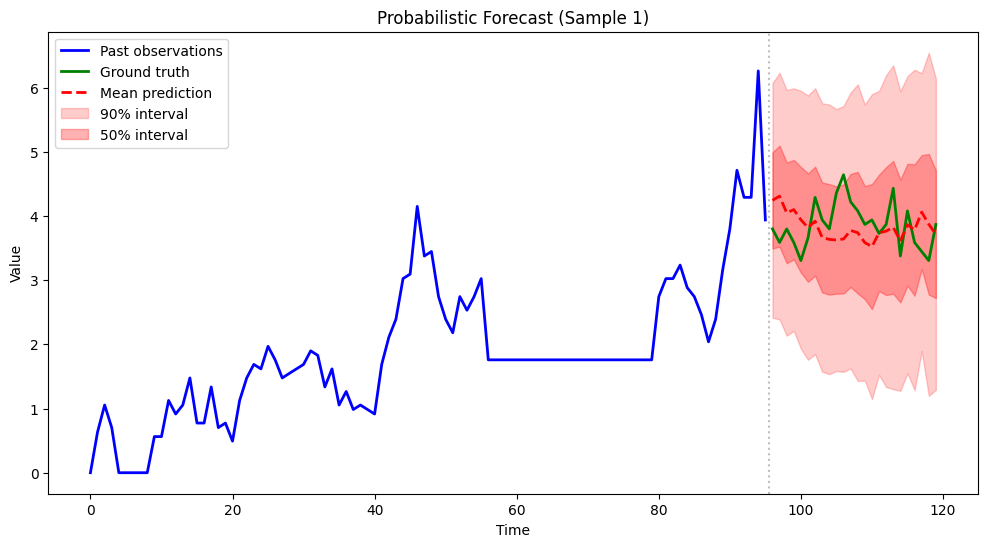

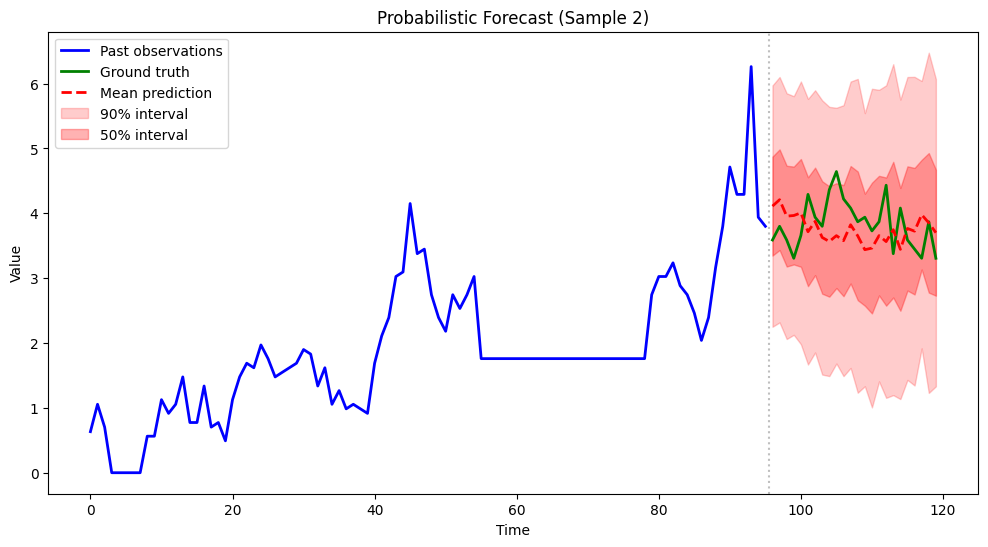

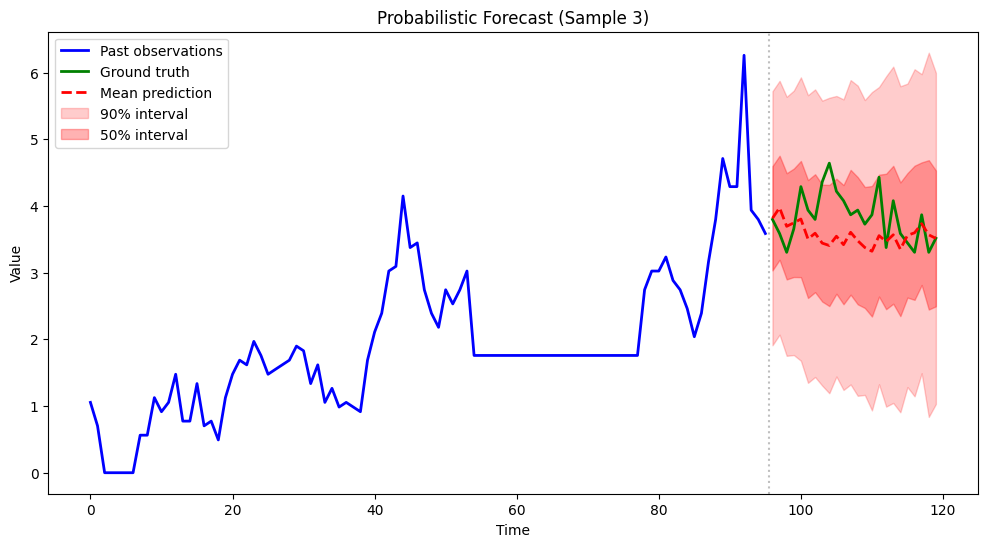

In [8]:
def visualize_probabilistic_forecast(model, dataloader, n_samples=3):
    """Visualize probabilistic forecasts with uncertainty intervals."""
    model.eval()
    past, future = next(iter(dataloader))
    
    for i in range(min(n_samples, past.shape[0])):
        with torch.no_grad():
            mean, logvar = model(past[i:i+1])
            mean = mean[0].numpy()
            std = torch.exp(0.5 * logvar[0]).numpy()
        
        # Compute quantiles
        q05 = mean - 1.645 * std  # 5th percentile (90% interval)
        q95 = mean + 1.645 * std  # 95th percentile
        q25 = mean - 0.6745 * std  # 25th percentile (50% interval)
        q75 = mean + 0.6745 * std  # 75th percentile
        
        plt.figure(figsize=(12, 6))
        
        # Plot past
        t_past = np.arange(past.shape[1])
        plt.plot(t_past, past[i].numpy(), 'b-', linewidth=2, label='Past observations')
        
        # Plot future
        t_future = np.arange(past.shape[1], past.shape[1] + horizon)
        plt.plot(t_future, future[i].numpy(), 'g-', linewidth=2, label='Ground truth')
        
        # Plot mean prediction
        plt.plot(t_future, mean, 'r--', linewidth=2, label='Mean prediction')
        
        # Plot uncertainty bands
        plt.fill_between(t_future, q05, q95, alpha=0.2, color='red', label='90% interval')
        plt.fill_between(t_future, q25, q75, alpha=0.3, color='red', label='50% interval')
        
        plt.axvline(x=past.shape[1]-0.5, color='gray', linestyle=':', alpha=0.5)
        plt.legend()
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title(f'Probabilistic Forecast (Sample {i+1})')
        plt.show()

visualize_probabilistic_forecast(prob_model, valid_dl, n_samples=3)

## Part 5: Quantile Regression

Quantile regression predicts multiple quantiles simultaneously, providing another
approach to uncertainty quantification without distributional assumptions.

**Question 6.** Implement quantile regression for forecasting using the below implementation for the quantile loss:
- Predict multiple quantiles (e.g., 10th, 50th, 90th percentiles)
- Visualize the quantile predictions

In [9]:
def quantile_loss(predictions, target, quantiles):
    """
    Quantile loss (pinball loss).
    
    Args:
        predictions: (batch, horizon, n_quantiles) - predicted quantiles
        target: (batch, horizon) - ground truth values
        quantiles: list of quantile values (e.g., [0.1, 0.5, 0.9])
    Returns:
        loss: scalar
    """
    target = target.unsqueeze(-1)  # (batch, horizon, 1)
    errors = target - predictions  # (batch, horizon, n_quantiles)
    
    quantiles_tensor = torch.tensor(quantiles, device=predictions.device).view(1, 1, -1)
    
    loss = torch.max(
        quantiles_tensor * errors,
        (quantiles_tensor - 1) * errors
    )
    return loss.mean()

QuantileForecaster
Epoch 00 | train=3.9436 | valid=0.9970
Epoch 01 | train=0.8249 | valid=0.7562
Epoch 02 | train=0.7245 | valid=0.6993
Epoch 03 | train=0.6868 | valid=0.6713
Epoch 04 | train=0.6635 | valid=0.6536
Epoch 05 | train=0.6476 | valid=0.6405
Epoch 06 | train=0.6354 | valid=0.6307
Epoch 07 | train=0.6247 | valid=0.6182
Epoch 08 | train=0.6173 | valid=0.6107
Epoch 09 | train=0.6090 | valid=0.6039
Epoch 10 | train=0.6028 | valid=0.6010
Epoch 11 | train=0.5975 | valid=0.6101
Epoch 12 | train=0.5934 | valid=0.5873
Epoch 13 | train=0.5866 | valid=0.5829
Epoch 14 | train=0.5837 | valid=0.5834
Epoch 15 | train=0.5793 | valid=0.5752
Epoch 16 | train=0.5761 | valid=0.5750
Epoch 17 | train=0.5740 | valid=0.5699
Epoch 18 | train=0.5703 | valid=0.5681
Epoch 19 | train=0.5682 | valid=0.5671


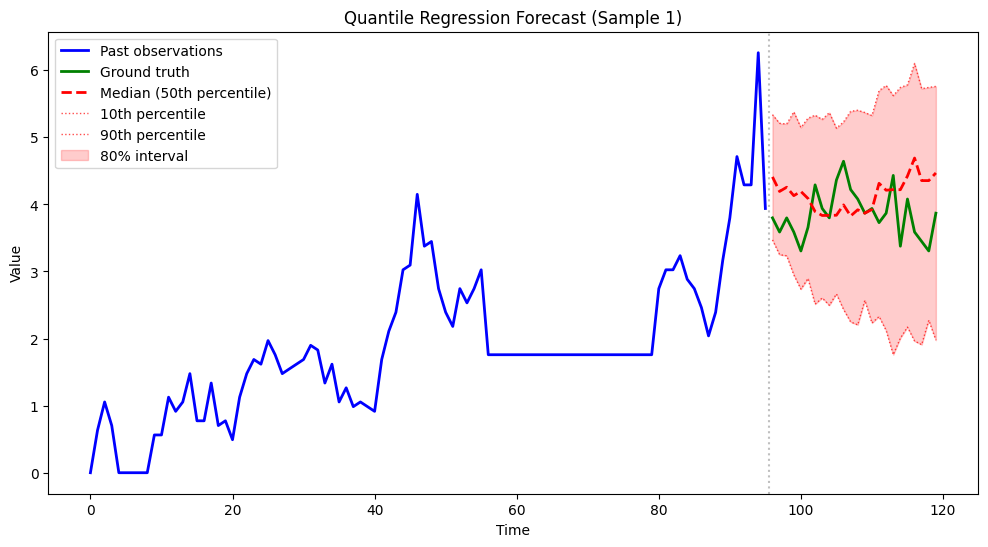

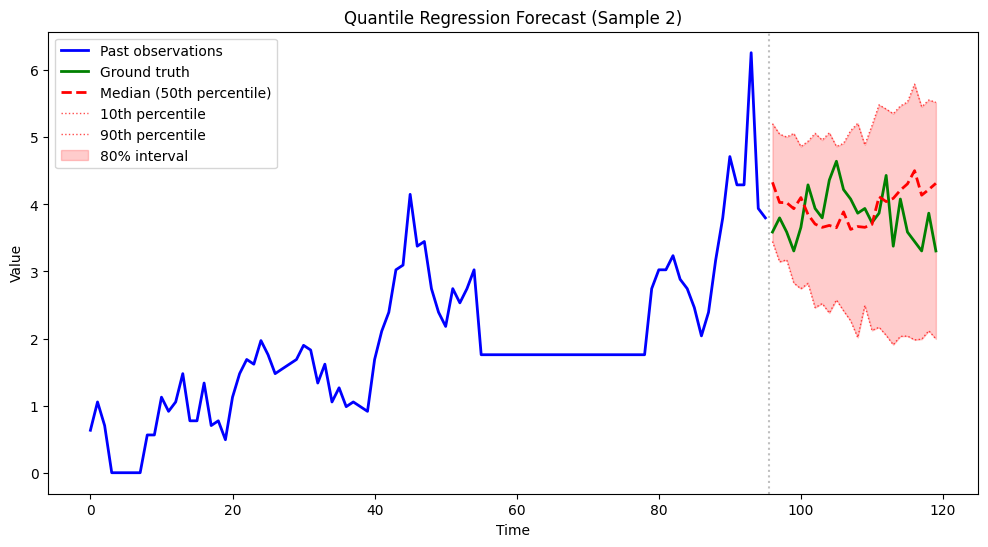

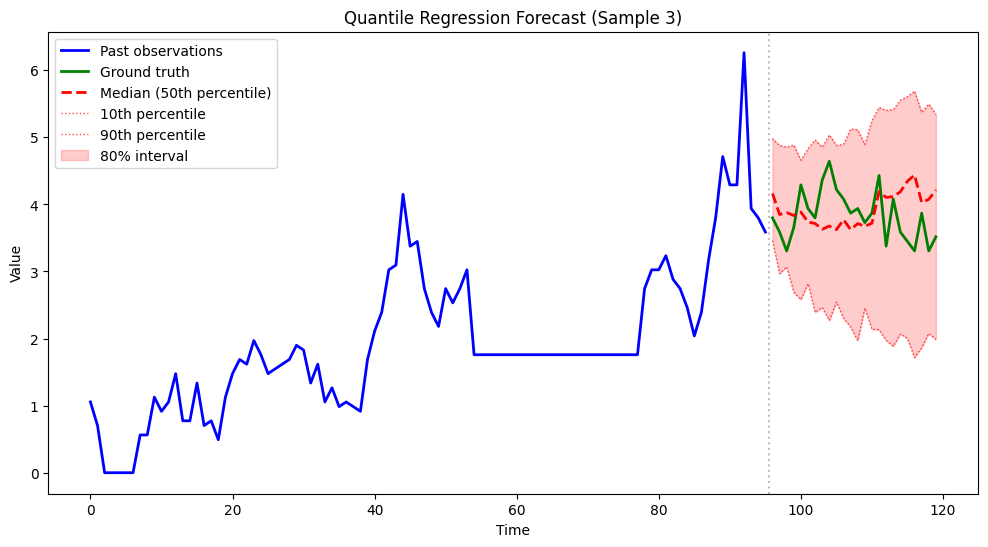

In [10]:
class QuantileForecaster(nn.Module):
    """Quantile regression forecaster: predicts multiple quantiles."""
    
    def __init__(self, window: int, horizon: int, quantiles: list = [0.1, 0.5, 0.9], 
                 hidden_dim: int = 64):
        super().__init__()
        self.window = window
        self.horizon = horizon
        self.quantiles = quantiles
        
        # Shared encoder
        self.encoder = nn.Sequential(
            nn.Linear(window, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        
        # Separate head for each quantile
        self.quantile_heads = nn.ModuleList([
            nn.Linear(hidden_dim, horizon) for _ in quantiles
        ])
    
    def forward(self, past):
        """
        Args:
            past: (batch, window)
        Returns:
            predictions: (batch, horizon, n_quantiles)
        """
        features = self.encoder(past)
        quantile_preds = [head(features) for head in self.quantile_heads]
        return torch.stack(quantile_preds, dim=-1)  # (batch, horizon, n_quantiles)


def train_quantile(model, dataloader, optimizer, quantiles, n_epochs=20):
    """Train quantile regression model."""
    logs = {"train_loss": [], "valid_loss": []}
    print(model.__class__.__name__)
    
    for epoch in range(n_epochs):
        # Training
        model.train()
        total_loss = 0.0
        for past, future in dataloader:
            optimizer.zero_grad()
            pred = model(past)
            loss = quantile_loss(pred, future, quantiles)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * past.size(0)
        train_loss = total_loss / len(dataloader.dataset)
        logs["train_loss"].append(train_loss)
        
        # Validation
        model.eval()
        total_loss = 0.0
        with torch.no_grad():
            for past, future in dataloader:
                pred = model(past)
                loss = quantile_loss(pred, future, quantiles)
                total_loss += loss.item() * past.size(0)
        valid_loss = total_loss / len(dataloader.dataset)
        logs["valid_loss"].append(valid_loss)
        
        print(f"Epoch {epoch:02d} | train={train_loss:.4f} | valid={valid_loss:.4f}")
    
    return logs

# Train quantile regression model
quantiles = [0.1, 0.5, 0.9]
quantile_model = QuantileForecaster(window, horizon, quantiles=quantiles)
optimizer_quantile = torch.optim.Adam(quantile_model.parameters(), lr=1e-4)
logs_quantile = train_quantile(quantile_model, train_dl, optimizer_quantile, quantiles, n_epochs=20)

# Visualize quantile predictions
def visualize_quantile_forecast(model, dataloader, n_samples=3):
    """Visualize quantile regression forecasts."""
    model.eval()
    past, future = next(iter(dataloader))
    
    for i in range(min(n_samples, past.shape[0])):
        with torch.no_grad():
            pred = model(past[i:i+1])  # (1, horizon, n_quantiles)
            pred = pred[0].numpy()  # (horizon, n_quantiles)
        
        plt.figure(figsize=(12, 6))
        
        # Plot past
        t_past = np.arange(past.shape[1])
        plt.plot(t_past, past[i].numpy(), 'b-', linewidth=2, label='Past observations')
        
        # Plot future
        t_future = np.arange(past.shape[1], past.shape[1] + horizon)
        plt.plot(t_future, future[i].numpy(), 'g-', linewidth=2, label='Ground truth')
        
        # Plot quantiles
        q_idx = {0.1: 0, 0.5: 1, 0.9: 2}
        plt.plot(t_future, pred[:, q_idx[0.5]], 'r--', linewidth=2, label='Median (50th percentile)')
        plt.plot(t_future, pred[:, q_idx[0.1]], 'r:', linewidth=1, alpha=0.7, label='10th percentile')
        plt.plot(t_future, pred[:, q_idx[0.9]], 'r:', linewidth=1, alpha=0.7, label='90th percentile')
        
        # Fill uncertainty bands
        plt.fill_between(t_future, pred[:, q_idx[0.1]], pred[:, q_idx[0.9]], 
                        alpha=0.2, color='red', label='80% interval')
        
        plt.axvline(x=past.shape[1]-0.5, color='gray', linestyle=':', alpha=0.5)
        plt.legend()
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title(f'Quantile Regression Forecast (Sample {i+1})')
        plt.show()

visualize_quantile_forecast(quantile_model, valid_dl, n_samples=3)